In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install shap
!{sys.executable} -m pip install lime

Looking in indexes: https://packages.repo.dvint.de/artifactory/api/pypi/py-mirror/simple/

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://packages.repo.dvint.de/artifactory/api/pypi/py-mirror/simple/

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://packages.repo.dvint.de/artifactory/api/pypi/py-mirror/simple/

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:

#Load useful libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from numpy import loadtxt
from xgboost import XGBClassifier

In [3]:
#LOAD AND EXPLORE DATA

In [4]:
#load diabetes dataset
diabetes_data = pd.read_csv('/home/remote/t08597a/PycharmProjects/xAI_demo/.venv/data/diabetes.csv')

#explore columns
diabetes_data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [5]:
#BASE CLASSIFIER

In [6]:
# Separate Features and Target Variables
X = diabetes_data.drop(columns='Outcome')
X.columns.tolist()
y = diabetes_data['Outcome']


In [7]:
#Create Train & Test Data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,
                                                	stratify =y,
                                                	random_state = 13)

In [9]:
# Build the model

In [10]:
model = XGBClassifier()
model.fit(X_train, y_train)

# Make prediction on the testing data
y_pred = model.predict(X_test)

# Classification Report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.83      0.78      0.81       158
           1       0.58      0.64      0.61        73

    accuracy                           0.74       231
   macro avg       0.70      0.71      0.71       231
weighted avg       0.75      0.74      0.74       231



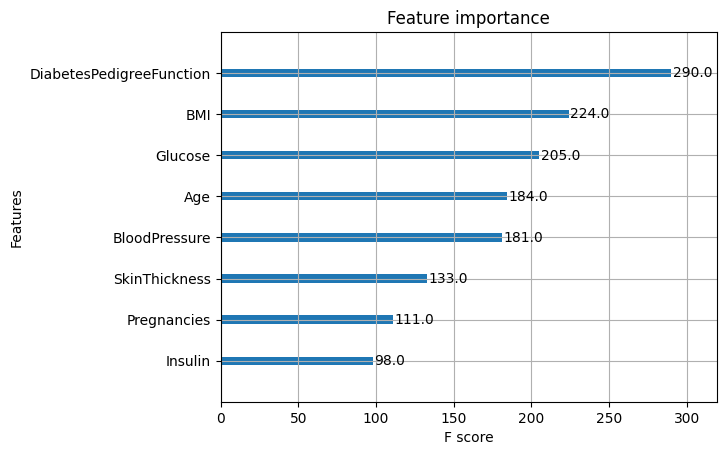

In [11]:
#intrinsic XGB global feature importance - with default importance type 'weight'
from xgboost import plot_importance
# plot feature importance
plot_importance(model)
plt.show()
plt.savefig('xgb_global_importance_weight', bbox_inches='tight')
plt.close()


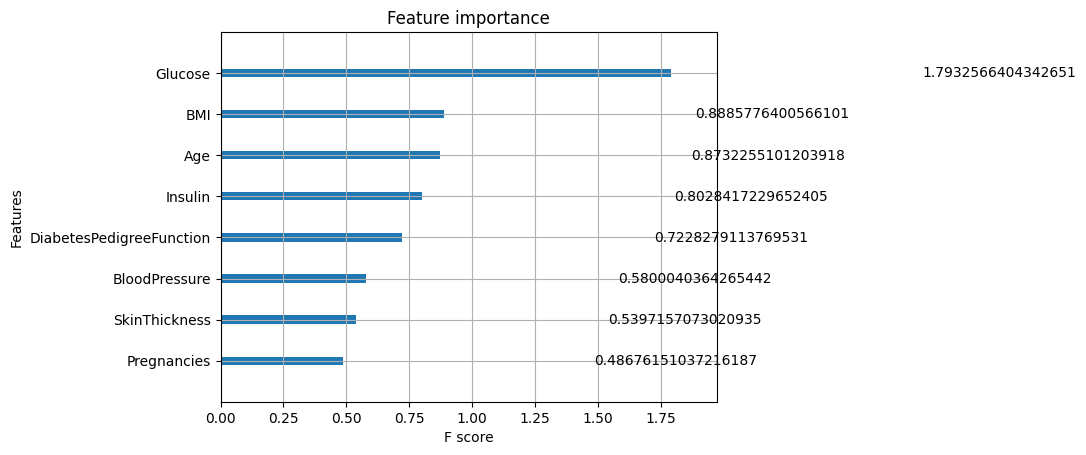

In [12]:
#intrinsic XGB global feature importance - with importance type 'gain'
from xgboost import plot_importance
# plot feature importance
plot_importance(model, importance_type='gain')
plt.show()
plt.savefig('xgb_global_importance_gain', bbox_inches='tight')
plt.close()


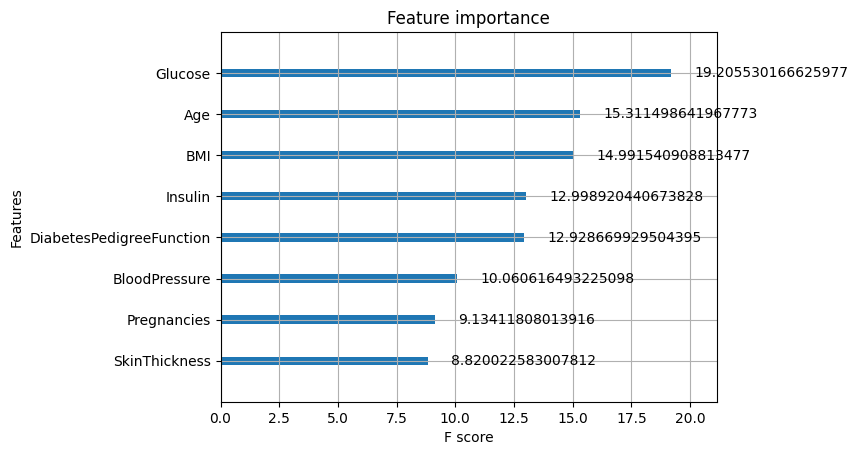

In [13]:
#intrinsic XGB global feature importance - with importance type 'cover
# plot feature importance
plot_importance(model, importance_type='cover')
plt.show()
plt.savefig('xgb_global_importance_cover', bbox_inches='tight')
plt.close()

In [14]:
# address the problem of inconsistent importance values across different xgb importance type calculations
#importance_type (str) –
	# How the importance is calculated: either “weight”, “gain”, or “cover”
	# ”weight” is the number of times a feature appears in a tree
	# ”gain” is the average gain of splits which use the feature
	# ”cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split


In [15]:
#SHAP

In [16]:
#INSTANTIATION

In [17]:
import shap

# load JS visualization code to notebook
shap.initjs()

# Create the explainer --> shap.TreeExplainer for all tree-based models, KernelExplainer for any other type of model --> slower, but GPU support available
explainer = shap.TreeExplainer(model, feature_names=X_train.columns.tolist())
shap_values_xgb = explainer.shap_values(X_train)


In [18]:
#Variable Importance with Summary Plot

Variable Importance Plot - Global Interpretation


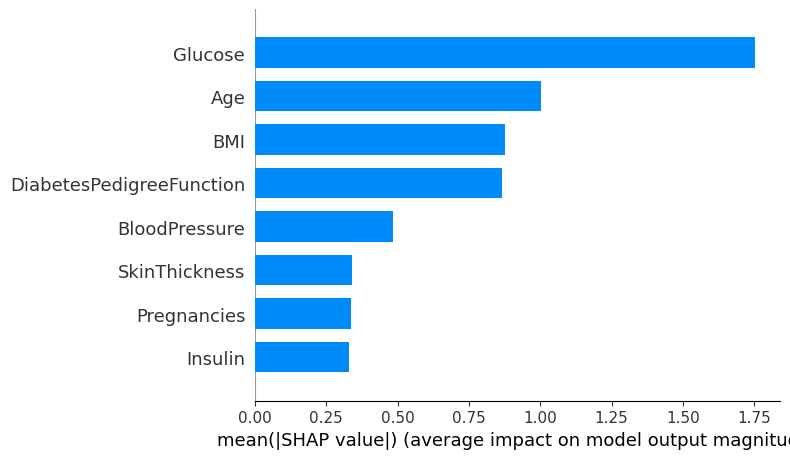

In [19]:
print("Variable Importance Plot - Global Interpretation")
figure_summary = shap.summary_plot(shap_values_xgb, feature_names=explainer.data_feature_names, plot_type="bar")
plt.savefig('shap_global_importance', bbox_inches='tight')
plt.close()

In [20]:
#doublecheck SHAP values for 'glucose'
pd.DataFrame(shap_values_xgb, columns=X_train.columns)["Glucose"].abs().mean()


1.7523357

In [21]:
#Now away from absolute importance values to more nunanced interpretations using SHAP

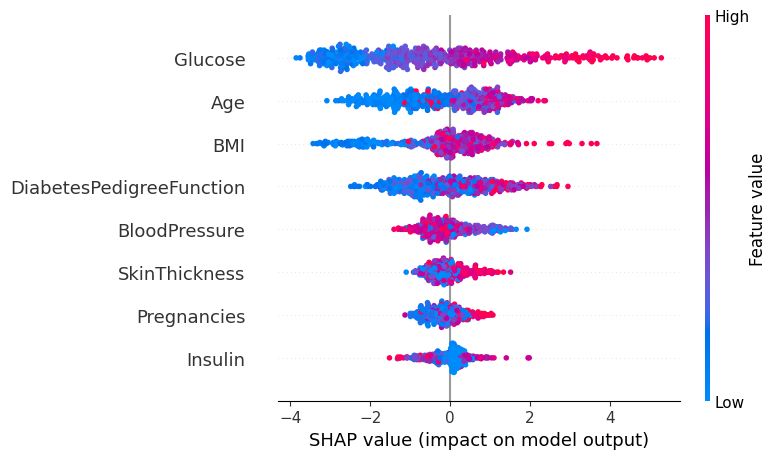

In [22]:
shap.summary_plot(shap_values_xgb, feature_names=explainer.data_feature_names, features=X_train)
plt.show()
plt.savefig('shap_global_importance_with_pos_neg', bbox_inches='tight')
plt.close()


In [23]:
#From above we can see some ambiguities for feature age
#One way of dealing with this ambiguity for the Age attribute is using the dependence plot to gain more insights.

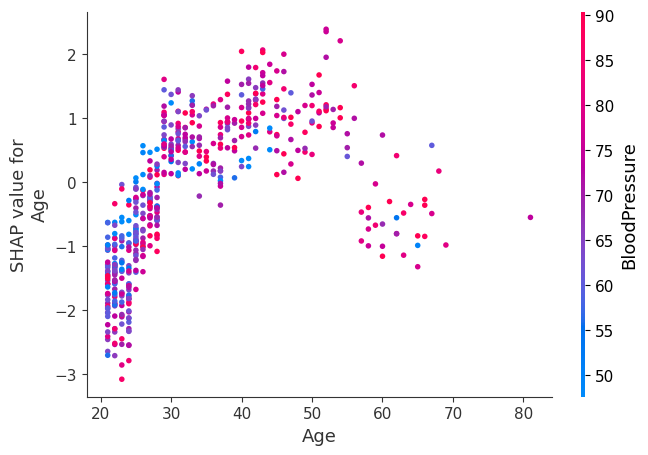

In [24]:
shap.dependence_plot("Age", shap_values_xgb, X_train)
plt.show()
plt.savefig('shap_dependence_age', bbox_inches='tight')
plt.close()

In [25]:
#feature interactions using SHAP

In [26]:
interactions = explainer.shap_interaction_values(X_train, y_train)

In [27]:
def get_top_k_interactions(feature_names, shap_interactions, k):
    # Get the mean absolute contribution for each feature interaction
    aggregate_interactions = np.mean(np.abs(shap_interactions[:, :-1, :-1]), axis=0)
    interactions = []
    for i in range(aggregate_interactions.shape[0]):
        for j in range(aggregate_interactions.shape[1]):
            if j < i:
                interactions.append(
                    (
                        feature_names[i] + "-" + feature_names[j],
                        aggregate_interactions[i][j] * 2,
                    )
                )
    # sort by magnitude
    interactions.sort(key=lambda x: x[1], reverse=True)
    interaction_features, interaction_values = map(tuple, zip(*interactions))

    return interaction_features[:k], interaction_values[:k]

In [28]:
#top_10_inter_feats contains 10 of the strongest interactions between all possible pairs of features:

In [29]:
top_10_inter_feats, top_10_inter_vals = get_top_k_interactions(
    X_train.columns, interactions, 10
)


In [30]:
top_10_inter_feats

('DiabetesPedigreeFunction-BMI',
 'DiabetesPedigreeFunction-Glucose',
 'BMI-Glucose',
 'SkinThickness-Glucose',
 'BMI-Pregnancies',
 'Glucose-Pregnancies',
 'BloodPressure-Glucose',
 'Insulin-Glucose',
 'DiabetesPedigreeFunction-SkinThickness',
 'DiabetesPedigreeFunction-BloodPressure')

In [31]:
#plots these pairs based on their interaction strengths:

In [32]:
def plot_interaction_pairs(pairs, values):
    plt.bar(pairs, values)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    plt.savefig('shap_interactions', bbox_inches='tight')
    plt.close()


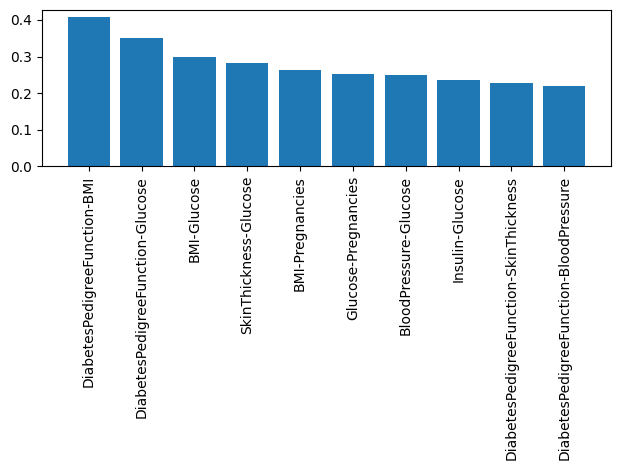

In [33]:
plot_interaction_pairs(top_10_inter_feats, top_10_inter_vals)

In [34]:
#--> to us not that insightful, rather intersting for epistemic curiosity to gain domain insights

In [35]:
# Now from global to local interpretability --> now on testset
# Recalculate SHAP values; We first recalculate the SHAP values using the explainer object.
# This is different than shap_values function, because this time, the Shapley values are returned with a 
# few more properties we need for local interpretability:


In [36]:
shap_explainer_values = explainer(X_test, y_test)

In [37]:
#local waterfall plot for random instance

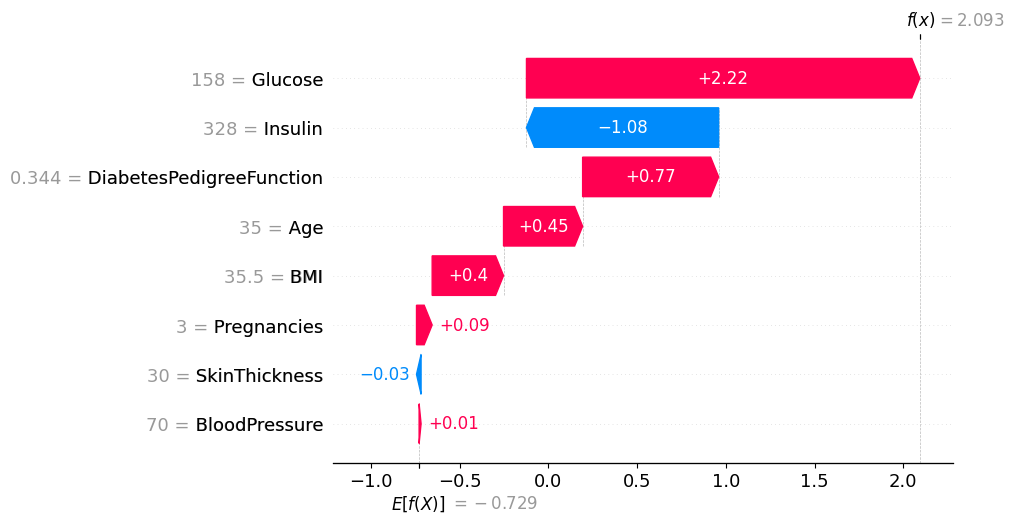

In [38]:
shap.waterfall_plot(shap_explainer_values[100])
plt.show()
plt.savefig('shap_local_waterfall', bbox_inches='tight', pad_inches=0.5)
plt.close()


In [39]:
#local forceplot for random instance from test dataset

In [40]:
shap.initjs()  # don't forget to enable JavaScript
shap.force_plot(shap_explainer_values[100])
#plt.show()
#plt.savefig('shap_local_forceplot', bbox_inches='tight', pad_inches=0.5)


In [41]:
#LIME

In [42]:
from lime.lime_tabular import LimeTabularExplainer


In [43]:
# Get the class names
class_names = ['No diabetes', 'Has diabetes']

# Get the feature names
feature_names = list(X_train.columns)

In [44]:
# Fit the Explainer on the training data set using the LimeTabularExplainer

In [45]:
explainer = LimeTabularExplainer(X_train.values, feature_names =     
                                 feature_names,
                                 class_names = class_names, 
                                 mode = 'classification')

In [46]:
exp=explainer.explain_instance(X_test.iloc[100], predict_fn=model.predict_proba)

/home/remote/t08597a/PycharmProjects/xAI_demo/.venv/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/remote/t08597a/PycharmProjects/xAI_demo/.venv/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/remote/t08597a/PycharmProjects/xAI_demo/.venv/lib/python3.10/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, i

In [47]:
exp.show_in_notebook(show_table=True, show_all=False)
